# Group Project ICS2205 - Task 1 

The file download from the "StatsBomb dataset link (Task 1)" on the VLE must be downloaded and extracted into the working directory for the program to work properly.

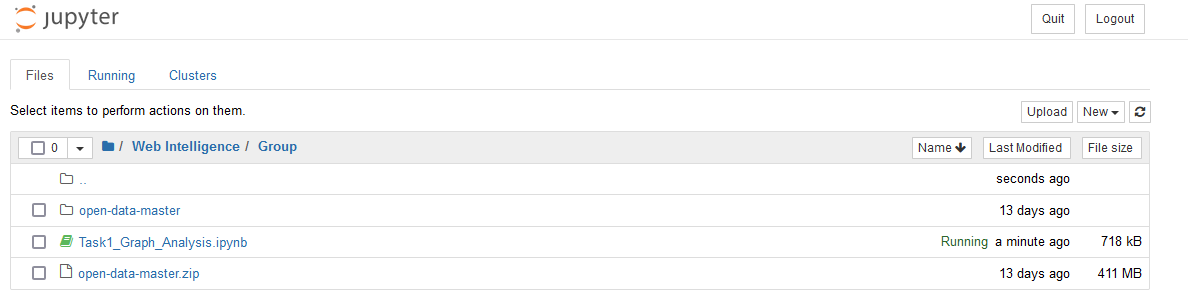

## 1

The program begins by parsing through all the match files to get the list of competitions.

After each file is parsed and stored in a dictionary, the user is allowed to choose which match they wish to use.

The program then makes function calls which get details about the game based on the match ID.

Lineups of both teams are first extracted from the relevant lineups file. 

Each event tagged as a pass is extractred and these passes are then checked to calculate how often each player passes to every other player.

The top 11 players, in terms of playing time, from each team are calculated. This is done by giving all the players in the starting 11 a start time of 0. If a player is substitued, then time of the substitution is placed as their end time. The substitute entering the field takes the time of substitution as their start time. At the end of the game any player who does not have an end time is given the full time as their end time. The end time is then subtracted by the start time to get the time played. These times are then sorted and only the top 11 of each team are displayed.

A passing network for each team is plotted by using the extracted passes between the top 11 players.

The program connects with neo4j and passes the network along with player names into neo4j desktop for querying.

## 2
The next functions all make use of the passing network generated in the previous functions to calculate certain results.

A simple function that counts the total number of passes using the edges (and their weight) in each team is called.

Using code from networkx website directly[1] a degree distribution graph is ploted

Simple inbuilt networkx methods are used to calculate the average path lenght and global clustering coefficient respectively

### References
[1] “Degree analysis,” Degree Analysis - NetworkX 3.0 documentation. [Online]. Available: https://networkx.org/documentation/stable/auto_examples/drawing/plot_degree.html. [Accessed: 06-Feb-2023]. 

## 3

### Who is the most active player in terms of passes?
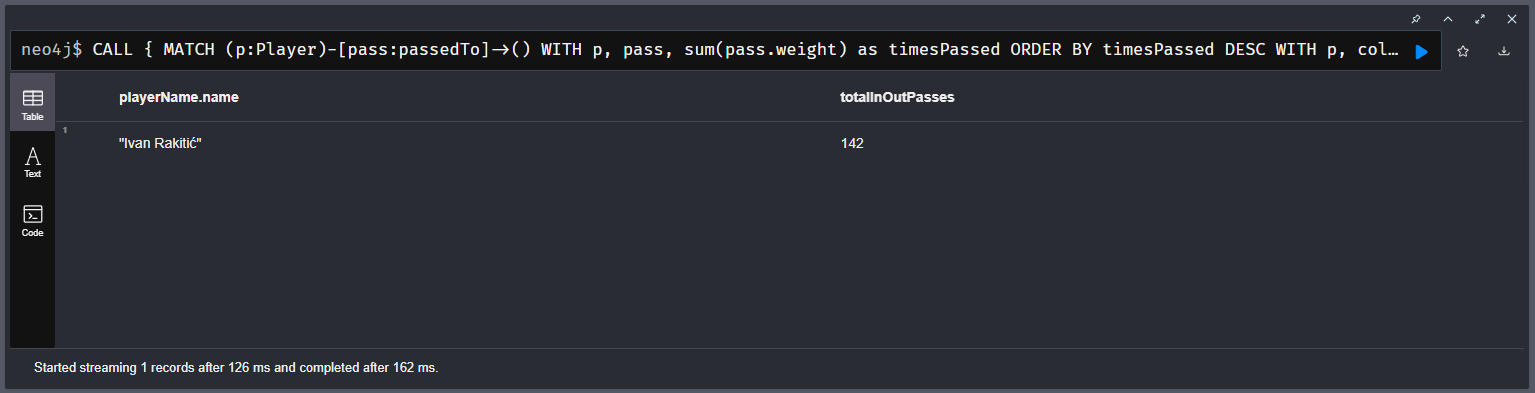

### Which players have an intermediary role (list the top 3 per team)?
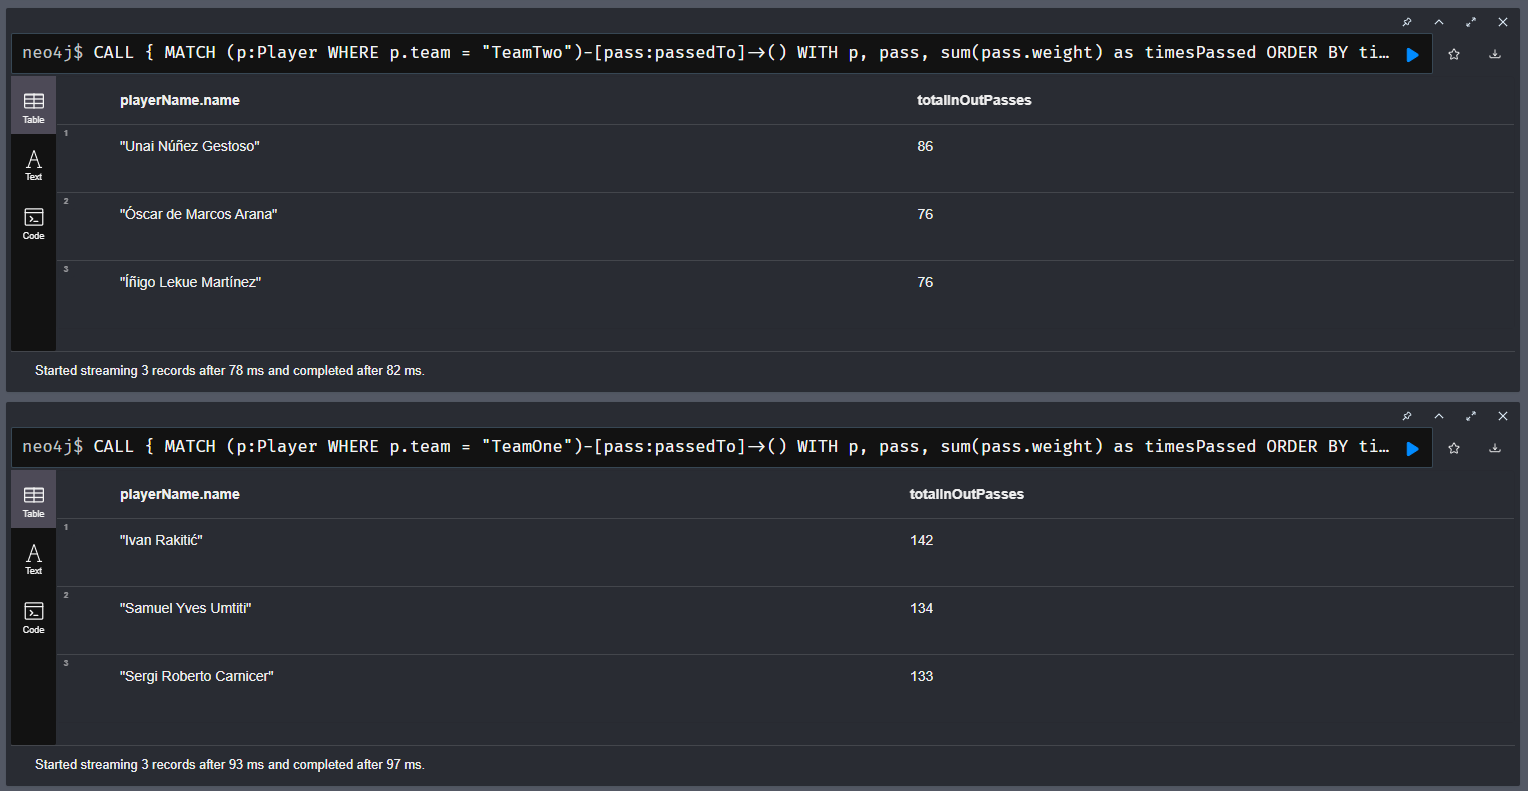

### How central is a player?
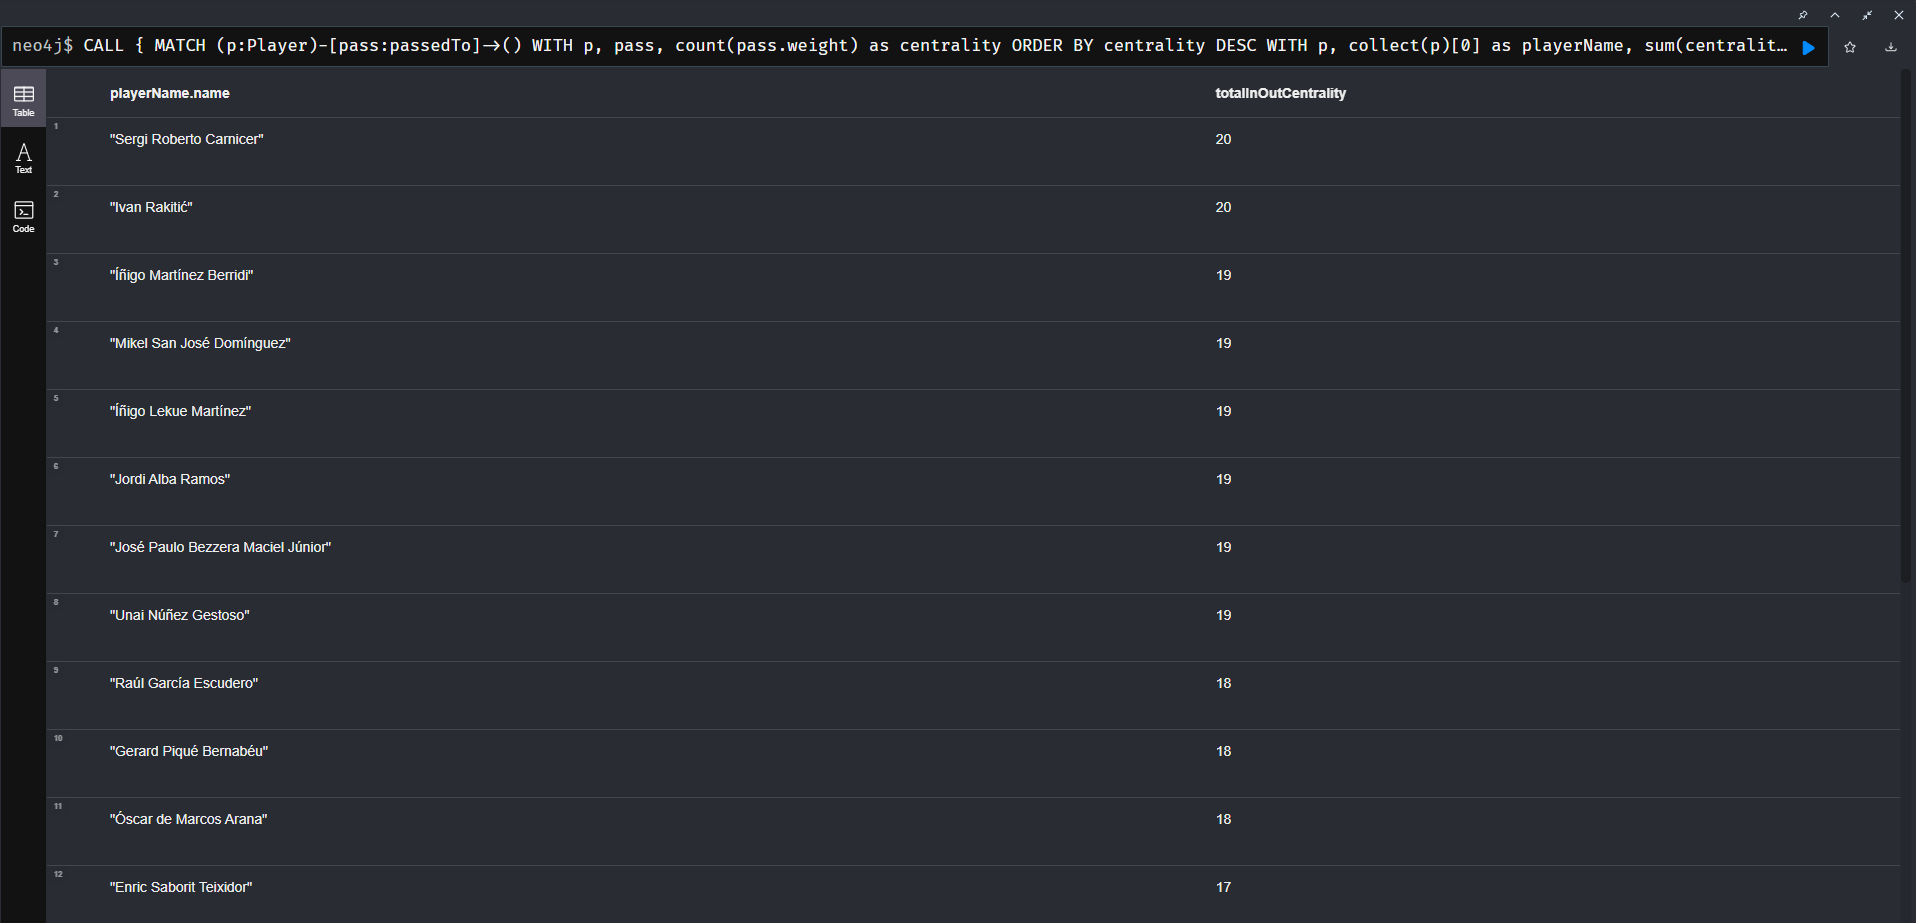

### Who is the player that recieved the highest number of passes?
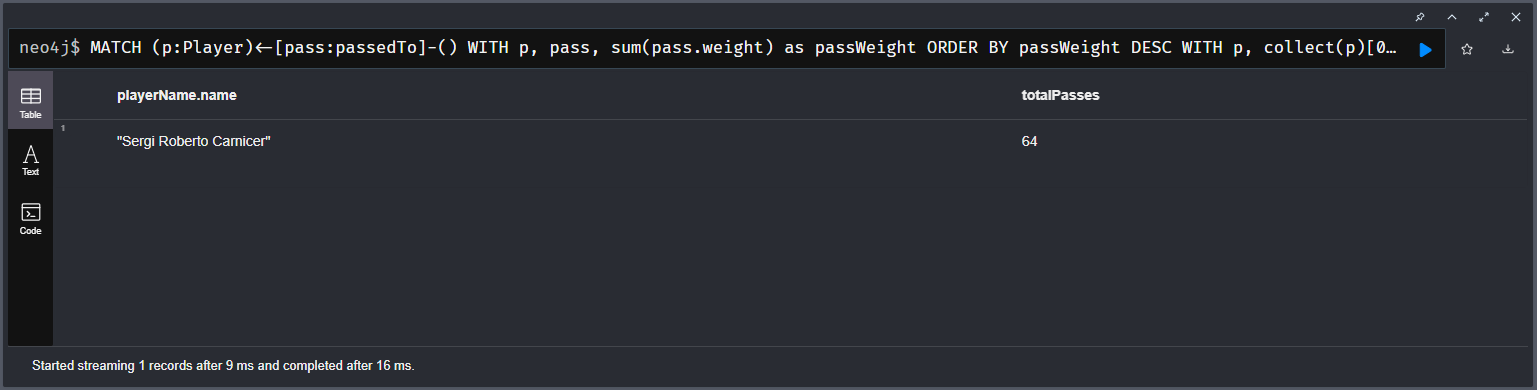

In [1]:
!pip install git+https://github.com/ybaktir/networkx-neo4j
!pip install networkx-neo4j


Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/ybaktir/networkx-neo4j to c:\users\janfo\appdata\local\temp\pip-req-build-2dkxygex
  Resolved https://github.com/ybaktir/networkx-neo4j to commit 97dc9563bf992ea9714cbdb99cb9e6a41c7cce65
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/ybaktir/networkx-neo4j 'C:\Users\janfo\AppData\Local\Temp\pip-req-build-2dkxygex'


Defaulting to user installation because normal site-packages is not writeable


In [2]:
#importing required packages
import json
import xml.etree.ElementTree as ET
import os
import networkx as nx
import nxneo4j
import matplotlib.pyplot as plot
from neo4j import GraphDatabase, basic_auth
import numpy as np

In [3]:
#Function to get list of competitions (1.1)

def ListOfCompetitions():
    #Get each subfolder under the mathes path
    MatchFilesPath = "open-data-master/data/matches"
    MatchFiles = os.listdir(MatchFilesPath)
    MatchFilesList = []

    CompetitionsList = {}

    #Get each file under the current subfolder
    for i in MatchFiles:
        tempPath = "open-data-master/data/matches/" + i
        tempMatchFiles = os.listdir(tempPath)
        #print(tempMatchFiles)

        tempVarCompName = ""
        SeasonMatchList = {}

        #Open each file under current subfolder
        for j in tempMatchFiles:
            tempFilePath = "open-data-master/data/matches/" + i + "/" + j
            #print(tempFilePath)
            tempFile = open(tempFilePath, encoding="utf8")
            #print(tempFile)
            tempFileData = json.load(tempFile)
            #print("")
            #print(tempFileData)

            if len(tempFileData) > 0:

                Season = tempFileData[0]["season"]["season_name"]
                SeasonMatchList[Season] = []

                for z in tempFileData:
                    competitionKey = z["competition"]["competition_name"]
                    if competitionKey not in CompetitionsList.keys():
                        tempVarCompName = competitionKey

                    SeasonMatchList[Season].append(z["match_id"])

            CompetitionsList[tempVarCompName] = SeasonMatchList

    return(CompetitionsList)

In [4]:
#extract the lineup for each team
def GetLineUps(Match):
    LineUpFile = open("open-data-master/data/lineups/"+str(Match)+".json", encoding="utf8")
    LineUpFileData = json.load(LineUpFile)
    #print(LineUpFileData)
    
    Lineups = {}
    LineupsNames = {}
    
    #goes through both teams
    for i in range(len(LineUpFileData)):
        TempLineup = []
        TempNameLineup = []
        tempTeam = LineUpFileData[i]["team_name"]
        #print(tempTeam)
        for j in range(len(LineUpFileData[0]["lineup"])):
            tempPlayer = LineUpFileData[i]["lineup"][j]["player_id"]
            tempPlayerName = LineUpFileData[i]["lineup"][j]["player_name"]
            TempLineup.append(tempPlayer)
            TempNameLineup.append(tempPlayerName)
            #print(tempPlayer)
            
            Lineups[tempTeam] = TempLineup
            LineupsNames[tempTeam] = TempNameLineup

    return(Lineups, LineupsNames)

In [5]:
#filter the data to extract the passes
def ExtractPasses(Match):
    EventsFile = open("open-data-master/data/events/"+str(Match)+".json", encoding="utf8")
    EventsFileData = json.load(EventsFile)
    
    passes = []
    
    #go through all events in the file
    for i in EventsFileData:
        #check if event is a pass
        if i["type"]["name"] == "Pass":
            if "recipient" in i["pass"]:
                passes.append([i["player"]["id"], i["pass"]["recipient"]["id"]])
                
    return passes
    
    #print(EventsFileData)

In [6]:
#get number of times that player A passes the ball to player B
def PassesBetween(Match, Passes):
    EventsFile = open("open-data-master/data/events/"+str(Match)+".json", encoding="utf8")
    EventsFileData = json.load(EventsFile)
    
    #print(len(Passes))
    PlayersPassing = {}
    
    for i in range(len(Passes)):
        Passer = Passes[i][0]
        PlayersPassing[Passer] = {}
    
    for i in range(len(Passes)):
        Passer = Passes[i][0]
        Recipient = Passes[i][1]
        
        try:
            PlayersPassing[Passer][Recipient] = PlayersPassing[Passer][Recipient] + 1
        except:
            PlayersPassing[Passer][Recipient] = 1
            
    counter =0
    for key in PlayersPassing:
        for key2 in PlayersPassing[key]:
            counter += PlayersPassing[key][key2]
    #print(counter)
    return PlayersPassing

In [7]:
#retrieve the top 11 players for each team based on the play-time
def TopPlayingTime(Match):
    EventsFile = open("open-data-master/data/events/"+str(Match)+".json", encoding="utf8")
    EventsFileData = json.load(EventsFile)
    
    PlayersPlayingTeamOne = {}
    PlayersPlayingTeamTwo = {}
    PlayerList = []
    TeamList = []
    
    for i in EventsFileData:
        if i["type"]["name"] == "Starting XI":
            TeamList.append(i["team"]["name"])
            
    #print(TeamList)
    
    for i in EventsFileData:
        if i["type"]["name"] == "Starting XI":
            
            if i["team"]["name"] == TeamList[0]:
                for j in(i["tactics"]["lineup"]):
                    Player = j["player"]["id"]
                    PlayersPlayingTeamOne[Player] = [0]

            
            if i["team"]["name"] == TeamList[1]:
                for j in(i["tactics"]["lineup"]):
                    Player = j["player"]["id"]
                    PlayersPlayingTeamTwo[Player] = [0]
                    
    #print(PlayersPlayingTeamOne)
    #print(PlayersPlayingTeamTwo)
    
    for i in EventsFileData:
        if i ["type"]["name"] == "Substitution":
            #print(i)
            #for j in (i[Substitution]):
                #print("")
            PlayerIn = (i["player"]["id"])
            PlayerOut = (i["substitution"]["replacement"]["id"])
            #print("In ",PlayerIn)
            #print("Out ",PlayerOut)

            
            #print(i["minute"])
            #print(i["second"])
            
            second = i["second"] / 60
            Timestamp = i["minute"] + second
            
            #print(Timestamp)
            #print("")
            
            if PlayerIn in PlayersPlayingTeamOne:
                #print("TeamOne")
                PlayersPlayingTeamOne[PlayerIn].append(Timestamp)
                templist = []
                templist.append(Timestamp)
                PlayersPlayingTeamOne[PlayerOut] = templist
                
            if PlayerIn in PlayersPlayingTeamTwo:
                #print("TeamTwo")
                PlayersPlayingTeamTwo[PlayerIn].append(Timestamp)
                templist = []
                templist.append(Timestamp)
                PlayersPlayingTeamTwo[PlayerOut] = templist
                
    for i in EventsFileData:
        if i ["type"]["name"] == "Half End":
            if i["period"] == 2:
                #print("Game End")
                
                EndSecond = i["second"] / 60
                EndTimeStamp = i["minute"] + EndSecond
                
                #print(EndTimeStamp)
                
                #print(len(PlayersPlayingTeamOne))
                for j in (PlayersPlayingTeamOne):
                    #print(PlayersPlayingTeamOne[j])
                    if(len(PlayersPlayingTeamOne[j])) < 2:
                        #print("less than 2")
                        PlayersPlayingTeamOne[j].append(EndTimeStamp)
                        
                    EnterStamp = PlayersPlayingTeamOne[j][0]
                    EndStamp = PlayersPlayingTeamOne[j][1]
                    TimePlayed = EndStamp - EnterStamp
                    
                    PlayersPlayingTeamOne[j] = []
                    PlayersPlayingTeamOne[j].append(TimePlayed)
                    PlayersPlayingTeamOne[j].append
                        
                for j in (PlayersPlayingTeamTwo):
                    #print(PlayersPlayingTeamOne[j])
                    if(len(PlayersPlayingTeamTwo[j])) < 2:
                        #print("less than 2")
                        PlayersPlayingTeamTwo[j].append(EndTimeStamp)
                        
                                            
                    EnterStamp = PlayersPlayingTeamTwo[j][0]
                    EndStamp = PlayersPlayingTeamTwo[j][1]
                    TimePlayed = EndStamp - EnterStamp
                    
                    PlayersPlayingTeamTwo[j] = TimePlayed
                break
            
    #print(PlayersPlayingTeamOne)
    #print(PlayersPlayingTeamTwo)
    
    sortedByPlayingTimeTeamOne = sorted(PlayersPlayingTeamOne.items(), reverse=True, key=lambda x:x[1])[:11]
    sortedByPlayingTimeTeamTwo = sorted(PlayersPlayingTeamTwo.items(), reverse=True, key=lambda x:x[1])[:11]
    #print(sortedByPlayingTime)
    
    PlayingTime = []
    PlayingTime.append(sortedByPlayingTimeTeamOne)
    PlayingTime.append(sortedByPlayingTimeTeamTwo)
    
    return PlayingTime
                

In [8]:
#generate and plot the passing network using networkX
def plotGraph1(Match, Passes, TopEleven, Lineups):
    EventsFile = open("open-data-master/data/events/"+str(Match)+".json", encoding="utf8")
    EventsFileData = json.load(EventsFile)
    
    TeamOne = nx.DiGraph()
    Teams = Lineups.keys()
    #print(Teams)
    
    #print(Lineups)
    
    for i in Teams:
        Team = i
        break;
    
    #LoopVar1 = 0
    
    #print(Team)
    #print(Lineups[Team][LoopVar1])
    
    #Loop through every key in the Passes dictionary
    
    for i in range(len(TopEleven)): #Loop Through top 11
        tempID = TopEleven[i][0]
        for j in range(len(TopEleven)):
            tempID2 = TopEleven[j][0]

            LoopVar = 0
            LoopVar2 = 0

            for r in range(len(Lineups[Team])):
                if Lineups[Team][r] == tempID:
                    LoopVar = r
                    break

            for r in range(len(Lineups[Team])):
                if Lineups[Team][r] == tempID2:
                    LoopVar2 = r
                    break
            
            testWeight = 0 #See if a pass actually occured
            try:
                testWeight = Passes[tempID][tempID2] #If a pass occured, continue normally
            except:
                continue #Continue to next iteration loop at failure of identifying pass

            if LoopVar != LoopVar2:
                TeamOne.add_edge(Lineups[Team][LoopVar], Lineups[Team][LoopVar2], weight =  Passes[tempID][tempID2])
        
    #setting for graph
    plot.figure(figsize = (10 , 10))
    teamPos = nx.spring_layout(TeamOne, k=5, iterations=50)
    options = {"node_color": "blue", "node_size":5000, "edge_color":"grey", "width": .50, "alpha": 0.7}
    nx.draw(TeamOne, pos = teamPos, with_labels = True, **options)
    OutPut1 = nx.draw_networkx_edge_labels(TeamOne, pos = teamPos, edge_labels = {}, font_color="black")
    
    return TeamOne

In [9]:
#generate and plot the passing network using networkX
def plotGraph2(Match, Passes, TopEleven, Lineups):
    EventsFile = open("open-data-master/data/events/"+str(Match)+".json", encoding="utf8")
    EventsFileData = json.load(EventsFile)
    
    TeamTwo = nx.DiGraph()
   
    Teams = Lineups.keys()
    #print(Teams)
    
    #print(Lineups)
    
    for i in Teams:
        Team = i
    
    #LoopVar1 = 0
    
    #print(Team)
    #print(Lineups[Team][LoopVar1])
    
    #Loop through every key in the Passes dictionary
    
    for i in range(len(TopEleven)): #Loop Through top 11
        tempID = TopEleven[i][0]
        for j in range(len(TopEleven)):
            tempID2 = TopEleven[j][0]

            LoopVar = 0
            LoopVar2 = 0

            for r in range(len(Lineups[Team])):
                if Lineups[Team][r] == tempID:
                    LoopVar = r
                    break

            for r in range(len(Lineups[Team])):
                if Lineups[Team][r] == tempID2:
                    LoopVar2 = r
                    break
            
            testWeight = 0
            try:
                testWeight = Passes[tempID][tempID2] #If a pass occured, continue normally
            except:
                continue #Continue to next iteration loop at failure of identifying pass
            if LoopVar != LoopVar2:
                TeamTwo.add_edge(Lineups[Team][LoopVar], Lineups[Team][LoopVar2], weight = Passes[tempID][tempID2])
        
    #setting for graph
    plot.figure(figsize = (10 , 10))
    teamPos = nx.spring_layout(TeamTwo, k=5, iterations=50)
    options = {"node_color": "blue", "node_size":5000, "edge_color":"grey", "width": .50, "alpha": 0.7}
    nx.draw(TeamTwo, pos = teamPos, with_labels = True, **options)
    OutPut2 = nx.draw_networkx_edge_labels(TeamTwo, pos = teamPos, edge_labels = {}, font_color="black")
    
    return TeamTwo

In [10]:
def conNeo4(TopEleven, Passes, Lineups, LineupsNames):
    #Connect to neo4j 
    driver = GraphDatabase.driver("bolt://localhost:7687", auth=basic_auth("neo4j","1234"))

    cfg ={'node_label': 'Player', 'relationship_type': 'passedTo', 'identifier_propery': 'name',
    }

    Diagram = nxneo4j.DiGraph(driver, config = cfg)
    Diagram.delete_all()

    Teams = Lineups.keys()
    
    for i in Teams:        
        Team = i
        break;
    Team1 = Team
    
    for i in Teams:        
        Team = i
    Team2 = Team
    
    #print(Team1)
    #print(Team2)

    #print(len(TopEleven[0]))
    
#     print(TopEleven[0])
    
    for i in range(len(TopEleven[0])): #Loop Through top 11
        tempID = TopEleven[0][i][0]
        for j in range(len(TopEleven[0])):
            tempID2 = TopEleven[0][j][0]

            LoopVar = 0
            LoopVar2 = 0

            for r in range(len(Lineups[Team2])):
                if Lineups[Team1][r] == tempID:
                    LoopVar = r
                    break

            for r in range(len(Lineups[Team2])):
                if Lineups[Team1][r] == tempID2:
                    LoopVar2 = r
                    break
                    
            testWeight = 0 #See if a pass actually occured
            try:
                testWeight = Passes[tempID][tempID2] #If a pass occured, continue normally
            except:
                continue #Continue to next iteration loop at failure of identifying pass
            
            if LoopVar != LoopVar2:
                Diagram.add_node(Lineups[Team1][LoopVar], team ="TeamOne", name = LineupsNames[Team1][LoopVar])
                Diagram.add_node(Lineups[Team1][LoopVar2], team ="TeamOne", name = LineupsNames[Team1][LoopVar2])
                Diagram.add_edge(Lineups[Team1][LoopVar], Lineups[Team1][LoopVar2], weight = Passes[tempID][tempID2], team="TeamOne")
    
    
    for i in range(len(TopEleven[1])): #Loop Through top 11
        tempID = TopEleven[1][i][0]
        for j in range(len(TopEleven[1])):
            tempID2 = TopEleven[1][j][0]
    
            LoopVar = 0
            LoopVar2 = 0

            for r in range(len(Lineups[Team2])):
                if Lineups[Team2][r] == tempID:
                    LoopVar = r
                    break
                    
            for r in range(len(Lineups[Team2])):
                if Lineups[Team2][r] == tempID2:
                    LoopVar2 = r
                    break
                    
            testWeight = 0 #See if a pass actually occured
            try:
                testWeight = Passes[tempID][tempID2] #If a pass occured, continue normally
            except:
                continue #Continue to next iteration loop at failure of identifying pass

            if LoopVar != LoopVar2:
                Diagram.add_node(Lineups[Team2][LoopVar], team ="TeamTwo", name = LineupsNames[Team2][LoopVar])
                Diagram.add_node(Lineups[Team2][LoopVar2], team ="TeamTwo", name = LineupsNames[Team2][LoopVar2])
                Diagram.add_edge(Lineups[Team2][LoopVar], Lineups[Team2][LoopVar2], weight = Passes[tempID][tempID2], team="TeamTwo")

In [11]:
def CountPasses(TeamOneGraph, TeamTwoGraph):
    PassCount1 = 0
    PassCount2 = 0
    
    for i,j,z in TeamOneGraph.edges(data=True):
        PassCount1 += z["weight"]
        
    for i,j,z in TeamTwoGraph.edges(data=True):
        PassCount2 += z["weight"]
    
    TotalPasses = []
    TotalPasses.append(PassCount1)
    TotalPasses.append(PassCount2)
    
    return TotalPasses

In [12]:
def DegreeDistribution(TeamGraph):
    
    #https://networkx.org/documentation/stable/auto_examples/drawing/plot_degree.html
    
    G = TeamGraph

    DegreeSequence = sorted((d for n, d in G.degree()), reverse = True)
    maxDegree = max(DegreeSequence)

    Diagram = plot.figure(figsize=(18, 18))
    # Create a gridspec for adding subplots of different sizes
    GraphGrid = Diagram.add_gridspec(5, 4)

    Graph = Diagram.add_subplot(GraphGrid[3:, :2])
    Graph.plot(DegreeSequence, "b-", marker="o")
    Graph.set_ylabel("Degree")
    Graph.set_xlabel("")

    Diagram.tight_layout()
    plot.show()
    
    return G

In [13]:
def AveragePathLength(TeamGraph):
    Average = nx.average_shortest_path_length(TeamGraph)
    return Average

In [14]:
def GlobalClusteringCoefficient(TeamGraph):
    Coefficient = nx.average_clustering(TeamGraph) 
    return Coefficient

In [15]:
#Get the list of competitions
CompetitionsList = ListOfCompetitions()
#print(CompetitionsList)

In [16]:
#Allow user to select match
print("Please select competition:")
for keys, i in CompetitionsList.items():
    print(keys)
Competition = input("Enter Competition Name:")

print("Please select season:")
for keys, i in CompetitionsList[Competition].items():
    print(keys)
Season = input("Enter Season:")

print("Please select match:")
print(CompetitionsList[Competition][Season])
Match = input("Enter Match ID:")

Match = int(Match)
for i in range(len((CompetitionsList[Competition][Season]))):
    if Match == CompetitionsList[Competition][Season][i]:
        Match = i
        
#print(Match)

Please select competition:
La Liga
Indian Super league
Champions League
Premier League
FA Women's Super League
FIFA World Cup
NWSL
UEFA Women's Euro
UEFA Euro
Women's World Cup
Enter Competition Name:La Liga
Please select season:
2017/2018
2016/2017
2009/2010
2010/2011
2011/2012
2012/2013
2013/2014
2014/2015
2015/2016
2004/2005
2005/2006
2006/2007
2018/2019
2007/2008
2008/2009
2019/2020
2020/2021
Enter Season:2017/2018
Please select match:
[9855, 9827, 9799, 9636, 9609, 9575, 9928, 9736, 9742, 9765, 9880, 9924, 9661, 9592, 9870, 9783, 9700, 9860, 9695, 9794, 9717, 9673, 9650, 9620, 9837, 9912, 9811, 9642, 9774, 9602, 9948, 9682, 9581, 9726, 9754, 9889]
Enter Match ID:9855


In [17]:
#Load event details and generate the passing networks
#Game = CompetitionsList["La Liga"]["2017/2018"][10]
print(Competition)
print(Season)
print(Match)
Match = int(Match)
Game = CompetitionsList[Competition][Season][Match]
#print(Game)

La Liga
2017/2018
0


In [18]:
#Function call to get lineups
LineupTypes = GetLineUps(Game)

Lineups = LineupTypes[0]
LineupsNames = LineupTypes[1]
print(Lineups)
print("")
print(LineupsNames)

{'Barcelona': [3501, 5211, 5213, 5216, 5470, 5477, 5492, 5503, 5542, 6196, 6379, 6400, 6402, 6849, 8652, 10802, 13599, 20055], 'Athletic Club': [6387, 6388, 6389, 6390, 6391, 6392, 6393, 6394, 6395, 6396, 6397, 6649, 6660, 6662, 6665, 6666, 6667, 6788]}

{'Barcelona': ['Philippe Coutinho Correia', 'Jordi Alba Ramos', 'Gerard Piqué Bernabéu', 'Andrés Iniesta Luján', 'Ivan Rakitić', 'Ousmane Dembélé', 'Samuel Yves Umtiti', 'Lionel Andrés Messi Cuccittini', 'José Paulo Bezzera Maciel Júnior', 'Yerry Fernando Mina González', 'Sergi Roberto Carnicer', 'Aleix Vidal Parreu', 'Francisco Alcácer García', 'Lucas Digne', 'Jasper Cillessen', 'André Filipe Tavares Gomes', 'Carles Aleña Castillo', 'Marc-André ter Stegen'], 'Athletic Club': ['Iñigo Córdoba Kerejeta', 'Ander Iturraspe Derteano', 'Mikel San José Domínguez', 'Markel Susaeta Laskurain', 'Raúl García Escudero', 'Íñigo Lekue Martínez', 'Iñaki Williams Arthuer', 'Aritz Aduriz Zubeldia', 'Kepa Arrizabalaga Revuelta', 'Beñat Etxebarria Urkiag

In [19]:
#Function call to extract passes
passes = ExtractPasses(Game)
print(passes)

[[6396, 6665], [6665, 6660], [6660, 6397], [6397, 6649], [6649, 6395], [6395, 6666], [5213, 5542], [6389, 6665], [6665, 6660], [6660, 6392], [6379, 5542], [5542, 6379], [6379, 5213], [5213, 5492], [5492, 20055], [20055, 5213], [5213, 6379], [6379, 5213], [5213, 20055], [20055, 5492], [5492, 6402], [6397, 6649], [5211, 5492], [5492, 5470], [5470, 5213], [5213, 6379], [6379, 5542], [5542, 5213], [5213, 5470], [5470, 6379], [6379, 5477], [6660, 6665], [6665, 6396], [6396, 6389], [6389, 6390], [5211, 5213], [5213, 6379], [6379, 5477], [5477, 5470], [5470, 5211], [5211, 3501], [3501, 5211], [5211, 5542], [5542, 5492], [5492, 5213], [5213, 5503], [5503, 5470], [5470, 5503], [5503, 5470], [5470, 5492], [5492, 3501], [6395, 6665], [6665, 6395], [6395, 6666], [5470, 5503], [5503, 6402], [6402, 5503], [5211, 6379], [6379, 5477], [6660, 6392], [6392, 6391], [6391, 6666], [5213, 6379], [6379, 5213], [5213, 5542], [6666, 6392], [6660, 6666], [6666, 6389], [6389, 6665], [6665, 6397], [6397, 6396], [

In [20]:
#Function call to get number of times that player A passes the ball to player B
PlayerPasses = PassesBetween(Game, passes)
print(PlayerPasses)

{6396: {6665: 5, 6389: 1, 6395: 1, 6392: 2, 6390: 3, 6660: 2, 6649: 1, 6666: 1}, 6665: {6660: 6, 6396: 2, 6395: 7, 6397: 5, 6666: 7, 6391: 2, 6390: 1, 6649: 2, 6392: 6, 6389: 2, 6388: 1, 6394: 2}, 6660: {6397: 2, 6392: 17, 6665: 8, 6666: 4, 6391: 4, 6396: 3, 6395: 2, 6649: 2, 6389: 1, 6388: 2, 6393: 2, 6394: 1}, 6397: {6649: 9, 6396: 1, 6395: 4, 6665: 7, 6660: 2, 6390: 8, 6391: 8, 6392: 1, 6666: 1, 6388: 2, 6389: 5, 6394: 2, 6393: 1}, 6649: {6395: 3, 6397: 10, 6390: 14, 6392: 3, 6389: 8, 6391: 4, 6396: 1, 6666: 1, 6665: 1, 6388: 2, 6393: 4}, 6395: {6666: 3, 6665: 4, 6389: 1, 6392: 2, 6397: 7, 6649: 2, 6391: 8, 6394: 2}, 5213: {5542: 3, 5492: 5, 6379: 23, 20055: 7, 5470: 9, 5503: 4, 5211: 2, 5477: 6, 3501: 2, 6402: 1, 5216: 1, 6400: 1}, 6389: {6665: 4, 6390: 2, 6660: 3, 6649: 3, 6396: 2, 6391: 3, 6666: 1, 6388: 3, 6392: 3, 6397: 5, 6393: 2, 6394: 2}, 6379: {5542: 11, 5213: 12, 5477: 15, 5470: 8, 5503: 6, 6402: 6, 5211: 2, 20055: 4, 5492: 3, 3501: 2, 5216: 2}, 5542: {6379: 13, 5213: 3, 5

In [21]:
#Function call to get the playing time of the top 11 players in each team
TimePlayed = TopPlayingTime(Game)
print(TimePlayed[0])
print(TimePlayed[1])

[(20055, [92.03333333333333]), (6379, [92.03333333333333]), (5213, [92.03333333333333]), (5492, [92.03333333333333]), (5211, [92.03333333333333]), (5542, [92.03333333333333]), (5470, [92.03333333333333]), (5503, [92.03333333333333]), (3501, [84.46666666666667]), (6402, [73.36666666666666]), (5477, [63.25])]
[(6395, 92.03333333333333), (6649, 92.03333333333333), (6397, 92.03333333333333), (6665, 92.03333333333333), (6660, 92.03333333333333), (6389, 92.03333333333333), (6391, 92.03333333333333), (6392, 92.03333333333333), (6666, 70.56666666666666), (6390, 62.18333333333333), (6388, 47.016666666666666)]


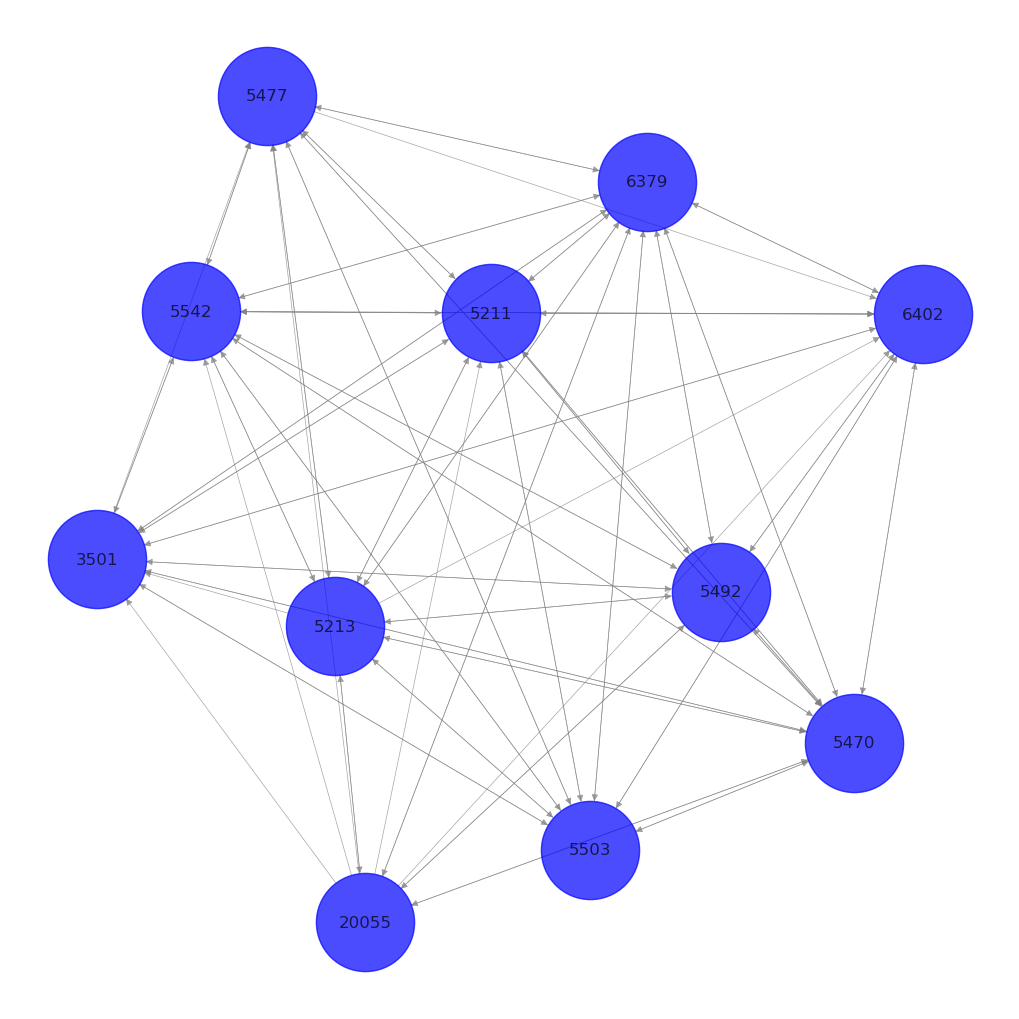

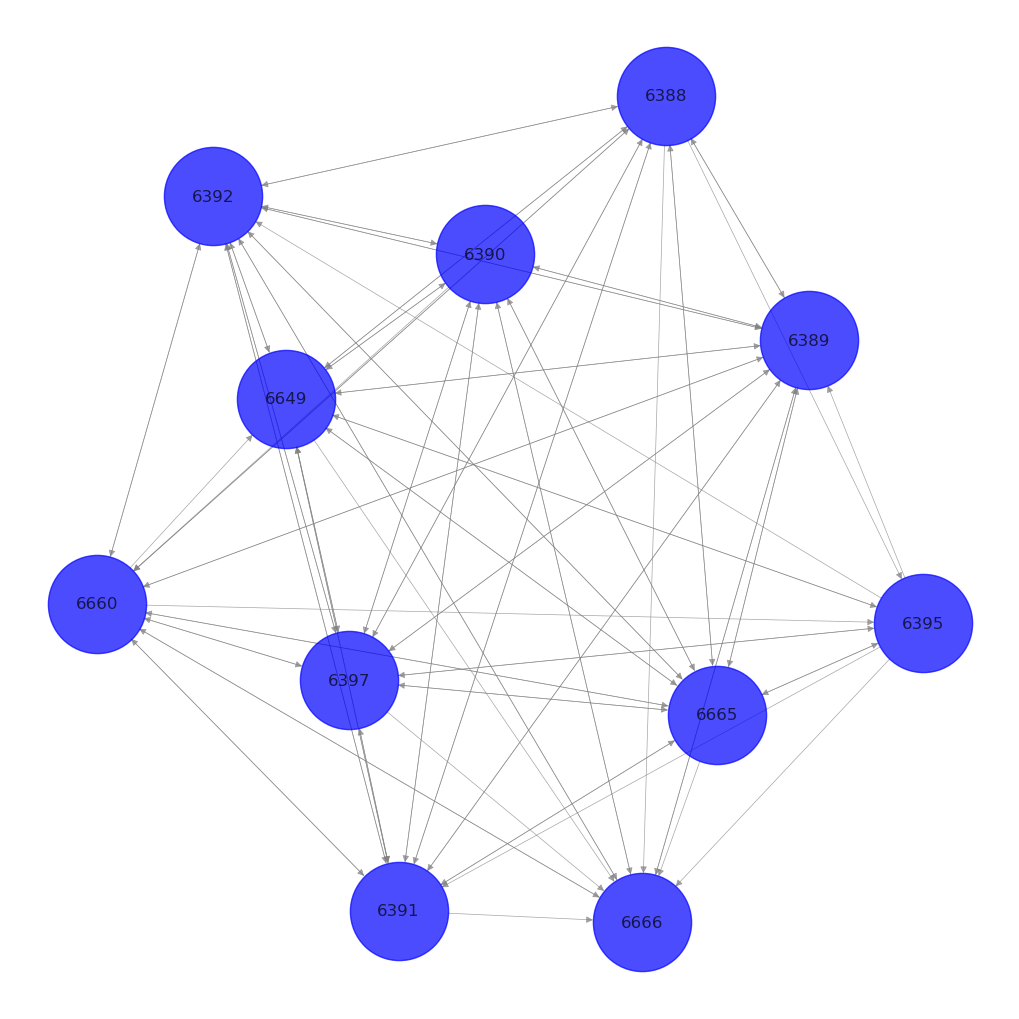

In [22]:
#Function to generate and plot the passing network using networkX
GraphTeamOne = plotGraph1(Game, PlayerPasses, TimePlayed[0], Lineups)
GraphTeamTwo = plotGraph2(Game, PlayerPasses, TimePlayed[1], Lineups)

In [23]:
#Function call to connect with Neo4j
conNeo4(TimePlayed, PlayerPasses,Lineups, LineupsNames)

In [24]:
#Analyse the underlying structure of the passing network
#function call to get total number of passes
TotalPasses = []
TotalPasses = CountPasses(GraphTeamOne, GraphTeamTwo)
PassCountTeam1 = TotalPasses[0]
print("Total number of passes by first team:")
print(PassCountTeam1)
PassCountTeam2 = TotalPasses[1] 
print("Total number of passes by second team:")
print(PassCountTeam2)

Total number of passes by first team:
533
Total number of passes by second team:
344


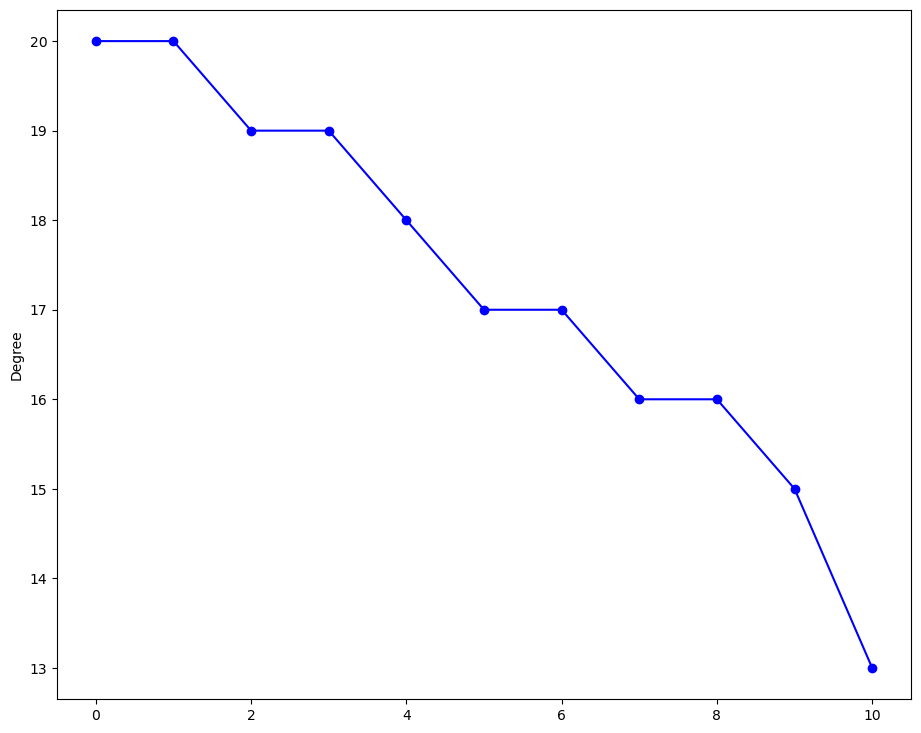

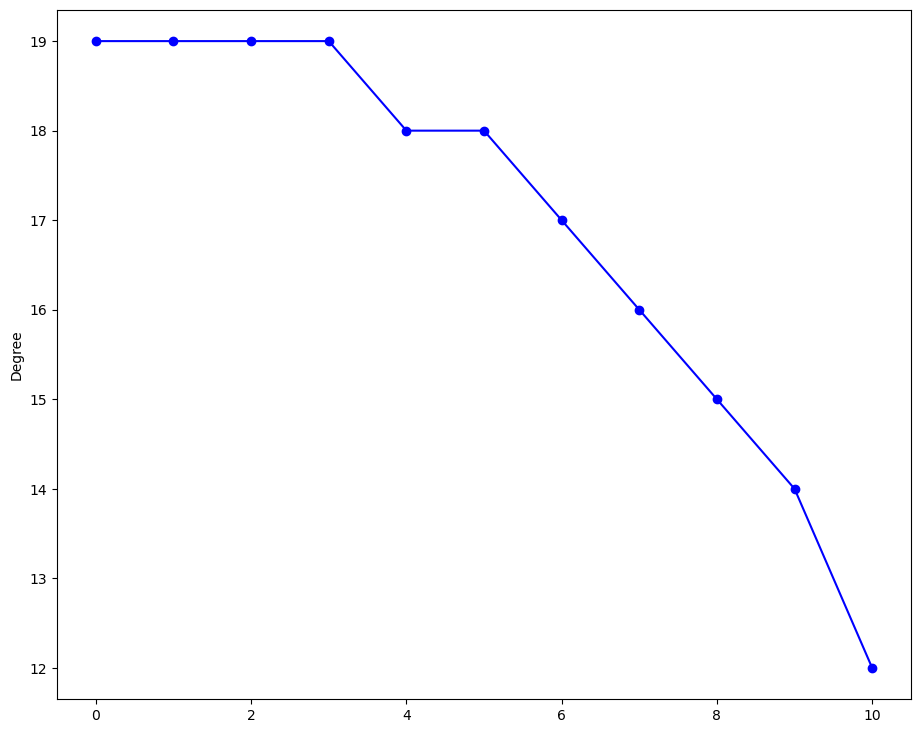

In [25]:
#function call to get the degree distribution of each graph
TeamOneDist = DegreeDistribution(GraphTeamOne)
TeamTwoDist = DegreeDistribution(GraphTeamTwo)

In [26]:
#function call to get average path length
TeamOnePathAvg = AveragePathLength(GraphTeamOne)
TeamTwoPathAvg = AveragePathLength(GraphTeamTwo)

print("Average Path Length, Team One: ")
print(TeamOnePathAvg)

print("Average Path Length, Team Two: ")
print(TeamTwoPathAvg)

Average Path Length, Team One: 
1.1363636363636365
Average Path Length, Team Two: 
1.1545454545454545


In [27]:
#function call to get global clustering coefficient
TeamOneCoefficient = GlobalClusteringCoefficient(GraphTeamOne)
print("Team One Global Coefficient: ",TeamOneCoefficient)

TeamTwoCoefficient = GlobalClusteringCoefficient(GraphTeamTwo)
print("Team Two Global Coefficient: ",TeamTwoCoefficient)

Team One Global Coefficient:  0.8833808361851424
Team Two Global Coefficient:  0.8681341726744921
